# PyTorch: Autoencoder convolucional Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [99]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

In [100]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [101]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [102]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [103]:
# 1.4)
#import google.colab
#from google.colab import files

In [104]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [105]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

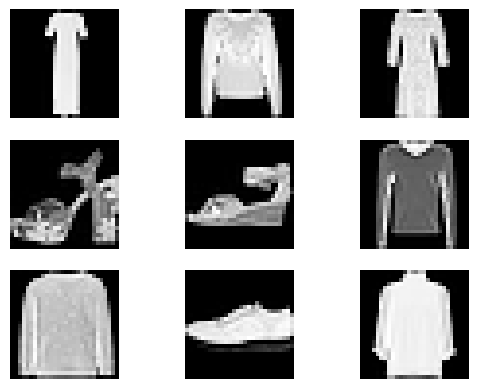

In [106]:
# 2.2)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    #plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

## Ejercicio 3) Creando un `DataSet` personalizado.

**1)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

**2)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.
Para ello, defina una clase `CustomDataset` que deriva de la clase `Dataset`, cuyo método `__getitem__(self,i)` retorne el pair `input,output` donde tanto `input` cómo `output` son iguales a la $i$-ésima imagen del dataset.

In [107]:
# 3.1)
# Creamos una subclase de la clase Dataset que nos sirva para generar lotes de ejemplos que puedan usarse para entrenar un autoencoder
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        input  = image
        output = image #torch.flatten(image) # retornamos la imagen como salida
        return input,output

In [108]:
# 3.2)
# Convertimos FashionMNIST Dataset a CustomDataset
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

## Ejercicio 4) Red Neuronal Autoencoder Convolucional

**1)** Defina y cree una red neuronal *autoencoder convolucional* constituida por las siguientes capas:


1. Capa convolucional 2D (encoder) compuesta por:

  * Una capa `Conv2d` (ver [documentación](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) que mapea una entrada con $1$ canal y dimensiones $(28,28)$ a una salida con $16$ canales y dimensiones $(26,26)$.
    Utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
  * Una capa `ReLU`.
  * Una capa `MaxPool2d` con un kernel de dimensiones $(2,2)$, de modo que la salida resultante tenga dimensiones $(16,13,13)$.
  * Una capa `Dropout` con probabilidad $p$.

2. Capa lineal (cuello de botella o “bottleneck”) compuesta por:

  * Una capa `Flatten` que transforma una entrada de dimensiones $(16,13,13)$ en un vector de dimensión $16\times 13\times 13 = 2704$.
  * Una capa `Linear` que mapea el vector de dimensión $2704$ a un vector de dimensión $n$ (donde $n$ es un número mucho menor, por ejemplo $n=128$, representando la *codificación comprimida* o *latente*).
  * Una capa `ReLU`.
  * Una capa `Linear` que mapea de nuevo el vector de dimensión $n$ al espacio original de dimensión $2704$.
  * Una capa `ReLU`.

3. Capa convolucional 2D transpuesta (decoder) compuesta por:

  * Una capa `Unflatten` que mapea el vector de dimensión $2704$ a una representación de $16$ canales con dimensiones $(13,13)$.
  * Una capa `ConvTranspose2d` (ver [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)) que mapea $16$ canales de dimensiones $(13,13)$ a $1$ canal de dimensiones $(28,28)$. Utilice un kernel de dimensiones $(6,6)$, un stride de $(2,2)$, y un padding de $(1,1)$.
  * Una capa `Sigmoid`, para asegurar que las salidas se encuentren en el rango $[0,1]$ (asumiendo que las imágenes originales también fueron normalizadas en dicho rango).

**2)** Grafique, a modo de comparación, algunas imágenes de entrada y sus correspondientes reconstrucciones obtenidas con el modelo **sin entrenar** y con una probabilidad de *dropout* $p=0.2$.

In [109]:
class AutoencoderExp1(nn.Module):
    """Experimento 1: Autoencoder convolucional básico"""

    def __init__(self, dropout = 0.2):
        super().__init__()
        # Encoder: (1, 28, 28) -> (32, 14, 14) -> (64, 7, 7)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # (1, 28, 28) -> (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 28, 28) -> (32, 14, 14)
            nn.Dropout(dropout),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # (32, 14, 14) -> (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 14, 14) -> (64, 7, 7)
        )

        # Decoder: (64, 7, 7) -> (32, 14, 14) -> (1, 28, 28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),  # (64, 7, 7) -> (32, 14, 14)
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2),  # (32, 14, 14) -> (1, 28, 28)
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class AutoencoderExp2(nn.Module):
    """Experimento 2: Autoencoder convolucional más profundo"""

    def __init__(self, dropout: float = 0.2):
        super().__init__()
        # Encoder: (1,28,28) -> (32,14,14) -> (64,7,7) -> (128,4,4)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 28->28
            nn.ReLU(),
            nn.MaxPool2d(2,2),                                     # 28->14
            nn.Dropout(dropout),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 14->14
            nn.ReLU(),
            nn.MaxPool2d(2,2),                                     # 14->7
            nn.Dropout(dropout),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),# 7->7
            nn.ReLU(),
            nn.MaxPool2d(2,2),                                     # 7->3
        )

        # Decoder: 3->7->14->28 
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0, output_padding=0), # 3->7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0, output_padding=0),   # 7->14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2, padding=0, output_padding=0),    # 14->28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class AutoencoderExp3(nn.Module):
    """Experimento 3: Autoencoder convolucional más pequeño (menos capacidad)"""

    def __init__(self, dropout: float = 0.2):
        super().__init__()
        # Encoder más chico: (1, 28, 28) -> (16, 14, 14) -> (32, 7, 7)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # (1, 28, 28) -> (16, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (16, 28, 28) -> (16, 14, 14)
            nn.Dropout(dropout),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (16, 14, 14) -> (32, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (32, 14, 14) -> (32, 7, 7)
        )

        # Decoder correspondiente: (32, 7, 7) -> (16, 14, 14) -> (1, 28, 28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # (32, 7, 7) -> (16, 14, 14)
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),  # (16, 14, 14) -> (1, 28, 28)
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [110]:
# 4.2) Probando las dimensiones de los modelos corregidos
p = 0.2

# Crear instancias de los tres modelos
model_exp1 = AutoencoderExp1(dropout=p)
model_exp2 = AutoencoderExp2(dropout=p)
model_exp3 = AutoencoderExp3(dropout=p)

print("Probando dimensiones de los modelos:")
print("=" * 50)

# Crear tensor de prueba
test_input = torch.randn(1, 1, 28, 28)
print(f"Input shape: {test_input.shape}")

# Probar cada modelo
for i, (model, name) in enumerate([(model_exp1, "AutoencoderExp1"), 
                                   (model_exp2, "AutoencoderExp2"), 
                                   (model_exp3, "AutoencoderExp3")]):
    model.eval()
    with torch.no_grad():
        try:
            output = model(test_input)
            print(f"\n{name}:")
            print(f"  Output shape: {output.shape}")
            print(f"  ✅ Dimensiones correctas: {output.shape[-2:] == (28, 28)}")
        except Exception as e:
            print(f"\n{name}:")
            print(f"  ❌ Error: {str(e)}")

print("\n" + "=" * 50)

Probando dimensiones de los modelos:
Input shape: torch.Size([1, 1, 28, 28])

AutoencoderExp1:
  Output shape: torch.Size([1, 1, 28, 28])
  ✅ Dimensiones correctas: True

AutoencoderExp2:
  Output shape: torch.Size([1, 1, 28, 28])
  ✅ Dimensiones correctas: True

AutoencoderExp3:
  Output shape: torch.Size([1, 1, 28, 28])
  ✅ Dimensiones correctas: True



In [111]:
# Create a dummy input tensor
image = torch.randn(1, 1, 28, 28) # batch size 1, channel 1, size 28x28
output = model(image)
print(f'Input size: (image.size())')
print(f'Output size: (output.size())')

Input size: (image.size())
Output size: (output.size())


In [112]:
def batch(x):
  return x.unsqueeze(0)   # (28,28) -> (1,28,28)

def unbatch(x):
  return x.squeeze().detach().cpu().numpy() # (1,28,28) -> (28,28)

In [113]:
image,_ = train_set[0]
batched_image = batch(image)
print('batches_image.size()=',batched_image.size())
pred_batched_image = model(batched_image)
print('pred_batched_image.size()=',pred_batched_image.size())
pred_image = unbatch(pred_batched_image)
print('pred_image.shape=',pred_image.shape)

batches_image.size()= torch.Size([1, 1, 28, 28])
pred_batched_image.size()= torch.Size([1, 1, 28, 28])
pred_image.shape= (28, 28)


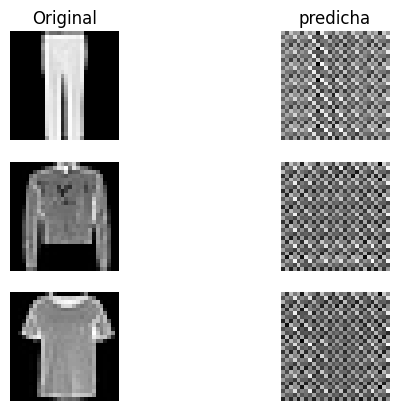

In [114]:
# Miramos que imagenes predice el modelo sin entrenar
figure = plt.figure()
rows,cols = 3,2
i = 0   #subplot index
for row in range(1, rows+1):
  j = torch.randint(len(train_set),size=(1,)).item()
  # Ploteamos la imagen original
  i = i + 1
  image,_ = train_set[j]
  figure.add_subplot(rows,cols,i)
  if row==1:
    plt.title('Original')
  plt.axis("off")
  plt.imshow(unbatch(image),cmap="Greys_r")
  # Ploteamos la imagen predicha
  i = i + 1
  figure.add_subplot(rows,cols,i)
  if row==1:
    plt.title('predicha')
  plt.axis("off")
  image_pred = unbatch(model(batch(image)))
  plt.imshow(image_pred,cmap="Greys_r")
plt.show()

## Ejercicio 5) Entrenando el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en listas correspondientes los siguientes valores del **ECM**:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **ECM** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

**12)** Repita para otras elecciones de los hiperparámetros tales como, el optimizador (podría ser el **SGD**), el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños.
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [115]:
# 5.1)
# Definimos la función de entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer,verbose=True):
    # Activamos la maquinaria de entrenamiento del modelo
    model.train()
    # Definimos ciertas constantes
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss = 0
    sum_samples = 0
    # Movemos el modelo a la GPU si es que está disponible
    model = model.to(device)
    #Iteramos sobre lotes (batchs)
    for batch, (X,y) in enumerate(dataloader):
        # Copiamos las entradas y salidas al dispositvo de trabajo si es que está disponible
        X = X.to(device)
        y = y.to(device)
        batch_size = len(X)
        sum_samples += batch_size
        # Calculamos la predicción del modelo y la correspondiente función de pérdida
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizaor provisto
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Calculamos la pérdida promedio del batch y lo agregamos a una suma correspondiente
        sum_loss += loss.item() * batch_size
        # Reportamos el progreso
        if batch % (num_batches/10) == 0 and verbose:
            current = batch*len(X)
            avrg_loss = sum_loss/sum_samples
            print(f'@train_loop batch={batch:>5d} loss={avrg_loss:>7f} proccesed samples={100*sum_samples/num_samples:>5f}%')
    avrg_loss = sum_loss/num_samples
    return avrg_loss


In [116]:
# 5.2)
# De manera similar, definimos la función de validación
def eval_loop(dataloader,model,loss_fn):
  # Desactivamos la maquinaria e entrenamiento del modelo
  model.eval()
  # Definimos ciertas constantes
  num_samples = len(dataloader.dataset)
  num_batches = len(dataloader)
  sum_loss = 0
  sum_samples = 0
  # Movemos el modelo a la GPU si es que está disponible
  model = model.to(device)
  # Para testear, desactivmos el cálculo de gradientes
  with torch.no_grad():
    # Iteramos sobre lotes (batches)
    for X,y in dataloader:
      # Copiamos las entradas y salidas al dispositvo de trabajo si es que está disponible
      X = X.to(device)
      y = y.to(device)
      batch_size = len(X)     # number of samples in the batch
      sum_samples += batch_size
      # Calculamos las predicciones del modelo
      pred = model(X)
      loss = loss_fn(pred,y)
      # Calculamos la pérdida promedio del batch y lo agregamos a una suma correspondiente
      sum_loss += loss.item() * batch_size
  # Calculamos la pérdida total y la fracción de clasificaciones correctas y las imprimimos
  avrg_loss = sum_loss/sum_samples
  #print(f'@eval loop avrg loss={avg loss:>8f}')
  return avrg_loss


In [117]:
# 5.3)
# Creamos los data loaders
batch_size = 100
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set,batch_size=batch_size,shuffle=True)

num_train_batches = len(train_loader)
num_valid_batches = len(valid_loader)
print(f'num_train_batches={num_train_batches}')
print(f'num_valid_batches={num_valid_batches}')

num_train_batches=600
num_valid_batches=100


In [118]:
# 5.4)
# Creamos una instancia de una función de pérdida, una entropy loss en este caso
#loss_fun = = nn.CrossEntropyLoss() # Para clasificación
loss_fn = nn.MSELoss() # Para autoencoder

In [119]:
# 5.5)
# Creamos el modelo
p = 0.2
model = AutoencoderExp1()

In [120]:
# 5.6)
# Creamos un optimizador, un Stochastic Gradient Descent o un ADAM
learning_rate = 1e-3
#optimizer = torch.optim.SGD(model.parameter(),lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [121]:
# 5.7)
# Determinamos en que dispositivo vamos a trabajar, con una CPU o GPU
devide = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)

In [122]:
# 5.8) y 5.9)
# Entrenamos los tres experimentos de autoencoder para comparar
import time

# Parámetros de entrenamiento
num_epochs = 50
learning_rate = 1e-3
dropout = 0.2
batch_size = 100

# Recreamos los data loaders con el batch_size actualizado
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

# Listas para almacenar las pérdidas de cada experimento
exp1_list_train_loss_incorrect = []
exp1_list_train_loss = []
exp1_list_valid_loss = []

exp2_list_train_loss_incorrect = []
exp2_list_train_loss = []
exp2_list_valid_loss = []

exp3_list_train_loss_incorrect = []
exp3_list_train_loss = []
exp3_list_valid_loss = []

# ========== EXPERIMENTO 1 ==========
print("Entrenando AutoencoderExp1...")
exp1_model = AutoencoderExp1(dropout=dropout)
exp1_optimizer = torch.optim.Adam(exp1_model.parameters(), lr=learning_rate)
exp1_model = exp1_model.to(device)

t_i = time.time()
for epoch in range(num_epochs):
    # Entrenamiento
    exp1_train_loss_incorrect = train_loop(train_loader, exp1_model, loss_fn, exp1_optimizer, verbose=False)
    exp1_list_train_loss_incorrect.append(exp1_train_loss_incorrect)
    # Evaluación en entrenamiento
    exp1_train_loss = eval_loop(train_loader, exp1_model, loss_fn)
    exp1_list_train_loss.append(exp1_train_loss)
    # Evaluación en validación
    exp1_valid_loss = eval_loop(valid_loader, exp1_model, loss_fn)
    exp1_list_valid_loss.append(exp1_valid_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={exp1_train_loss:.4f}, valid_loss={exp1_valid_loss:.4f}")

print(f"Exp1 - Tiempo de ejecución: {(time.time()-t_i)/60:.2f} minutos")

# ========== EXPERIMENTO 2 ==========
print("\nEntrenando AutoencoderExp2...")
exp2_model = AutoencoderExp2(dropout=dropout)
exp2_optimizer = torch.optim.Adam(exp2_model.parameters(), lr=learning_rate)
exp2_model = exp2_model.to(device)

t_i = time.time()
for epoch in range(num_epochs):
    # Entrenamiento
    exp2_train_loss_incorrect = train_loop(train_loader, exp2_model, loss_fn, exp2_optimizer, verbose=False)
    exp2_list_train_loss_incorrect.append(exp2_train_loss_incorrect)
    # Evaluación en entrenamiento
    exp2_train_loss = eval_loop(train_loader, exp2_model, loss_fn)
    exp2_list_train_loss.append(exp2_train_loss)
    # Evaluación en validación
    exp2_valid_loss = eval_loop(valid_loader, exp2_model, loss_fn)
    exp2_list_valid_loss.append(exp2_valid_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={exp2_train_loss:.4f}, valid_loss={exp2_valid_loss:.4f}")

print(f"Exp2 - Tiempo de ejecución: {(time.time()-t_i)/60:.2f} minutos")

# ========== EXPERIMENTO 3 ==========
print("\nEntrenando AutoencoderExp3...")
exp3_model = AutoencoderExp3(dropout=dropout)
exp3_optimizer = torch.optim.Adam(exp3_model.parameters(), lr=learning_rate)
exp3_model = exp3_model.to(device)

t_i = time.time()
for epoch in range(num_epochs):
    # Entrenamiento
    exp3_train_loss_incorrect = train_loop(train_loader, exp3_model, loss_fn, exp3_optimizer, verbose=False)
    exp3_list_train_loss_incorrect.append(exp3_train_loss_incorrect)
    # Evaluación en entrenamiento
    exp3_train_loss = eval_loop(train_loader, exp3_model, loss_fn)
    exp3_list_train_loss.append(exp3_train_loss)
    # Evaluación en validación
    exp3_valid_loss = eval_loop(valid_loader, exp3_model, loss_fn)
    exp3_list_valid_loss.append(exp3_valid_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={exp3_train_loss:.4f}, valid_loss={exp3_valid_loss:.4f}")

print(f"Exp3 - Tiempo de ejecución: {(time.time()-t_i)/60:.2f} minutos")
print('\nEntrenamiento de los 3 experimentos completado!')

Entrenando AutoencoderExp1...
Epoch 10/50: train_loss=0.5751, valid_loss=0.5727
Epoch 20/50: train_loss=0.5742, valid_loss=0.5718
Epoch 30/50: train_loss=0.5740, valid_loss=0.5715
Epoch 40/50: train_loss=0.5739, valid_loss=0.5714
Epoch 50/50: train_loss=0.5738, valid_loss=0.5714
Exp1 - Tiempo de ejecución: 45.87 minutos

Entrenando AutoencoderExp2...
Epoch 10/50: train_loss=0.6816, valid_loss=0.6786
Epoch 20/50: train_loss=0.6816, valid_loss=0.6786
Epoch 30/50: train_loss=0.5826, valid_loss=0.5803
Epoch 40/50: train_loss=0.5794, valid_loss=0.5771
Epoch 50/50: train_loss=0.5786, valid_loss=0.5762
Exp2 - Tiempo de ejecución: 64.12 minutos

Entrenando AutoencoderExp3...
Epoch 10/50: train_loss=0.5790, valid_loss=0.5765
Epoch 20/50: train_loss=0.5773, valid_loss=0.5749
Epoch 30/50: train_loss=0.5769, valid_loss=0.5744
Epoch 40/50: train_loss=0.5768, valid_loss=0.5743
Epoch 50/50: train_loss=0.5774, valid_loss=0.5749
Exp3 - Tiempo de ejecución: 29.76 minutos

Entrenamiento de los 3 experime

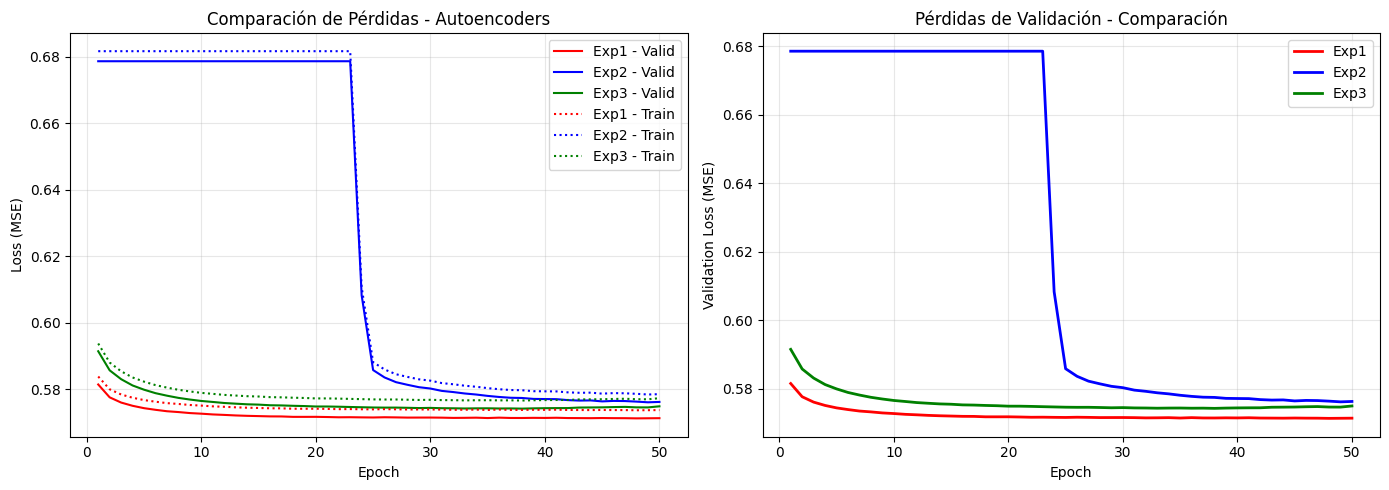

Pérdidas finales de validación:
Experimento 1: 0.571350
Experimento 2: 0.576233
Experimento 3: 0.574915


In [124]:
# Eje x: epochs
s = [i for i in range(1, num_epochs+1)]

# Gráfico de pérdidas
plt.figure(figsize=(14, 5))

# Subplot 1: Pérdidas de validación y entrenamiento
plt.subplot(1, 2, 1)
plt.plot(s, exp1_list_valid_loss, label='Exp1 - Valid', linestyle="-", c='red')
plt.plot(s, exp2_list_valid_loss, label='Exp2 - Valid', linestyle="-", c='blue')
plt.plot(s, exp3_list_valid_loss, label='Exp3 - Valid', linestyle="-", c='green')

plt.plot(s, exp1_list_train_loss, label='Exp1 - Train', linestyle=":", c='red')
plt.plot(s, exp2_list_train_loss, label='Exp2 - Train', linestyle=":", c='blue')
plt.plot(s, exp3_list_train_loss, label='Exp3 - Train', linestyle=":", c='green')

plt.title('Comparación de Pérdidas - Autoencoders')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Solo pérdidas de validación para mejor visualización
plt.subplot(1, 2, 2)
plt.plot(s, exp1_list_valid_loss, label='Exp1', linewidth=2, c='red')
plt.plot(s, exp2_list_valid_loss, label='Exp2', linewidth=2, c='blue')
plt.plot(s, exp3_list_valid_loss, label='Exp3', linewidth=2, c='green')

plt.title('Pérdidas de Validación - Comparación')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Imprimir pérdidas finales para comparación
print(f"Pérdidas finales de validación:")
print(f"Experimento 1: {exp1_list_valid_loss[-1]:.6f}")
print(f"Experimento 2: {exp2_list_valid_loss[-1]:.6f}")
print(f"Experimento 3: {exp3_list_valid_loss[-1]:.6f}")


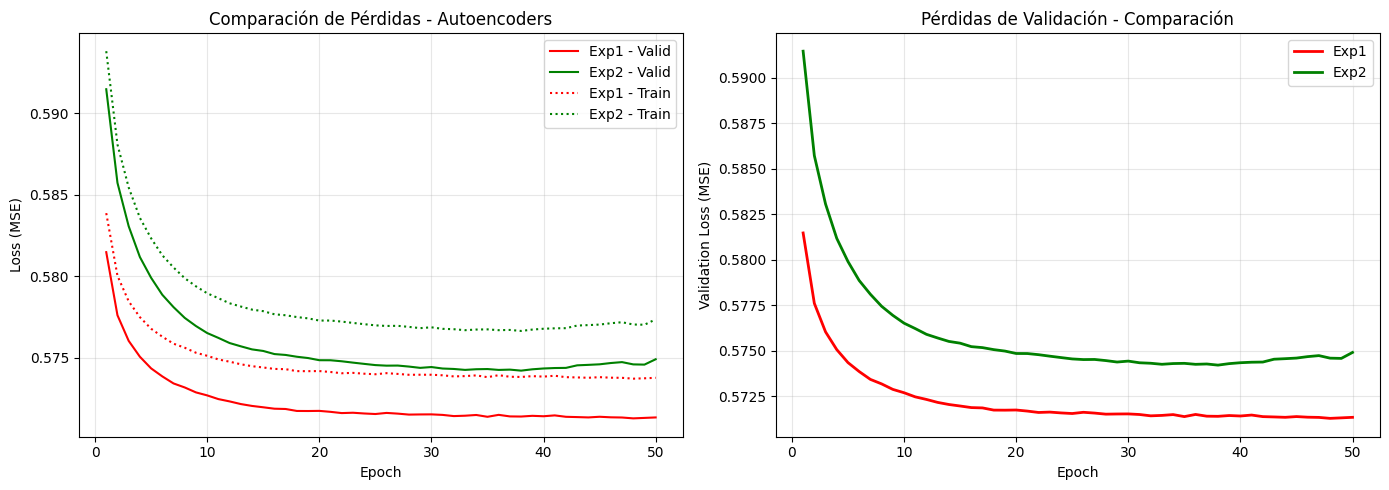

Pérdidas finales de validación:
Experimento 1: 0.571350
Experimento 2: 0.574915


In [125]:
# Eje x: epochs
s = [i for i in range(1, num_epochs+1)]

# Gráfico de pérdidas
plt.figure(figsize=(14, 5))

# Subplot 1: Pérdidas de validación y entrenamiento
plt.subplot(1, 2, 1)
plt.plot(s, exp1_list_valid_loss, label='Exp1 - Valid', linestyle="-", c='red')
plt.plot(s, exp3_list_valid_loss, label='Exp2 - Valid', linestyle="-", c='green')

plt.plot(s, exp1_list_train_loss, label='Exp1 - Train', linestyle=":", c='red')
plt.plot(s, exp3_list_train_loss, label='Exp2 - Train', linestyle=":", c='green')

plt.title('Comparación de Pérdidas - Autoencoders')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Solo pérdidas de validación para mejor visualización
plt.subplot(1, 2, 2)
plt.plot(s, exp1_list_valid_loss, label='Exp1', linewidth=2, c='red')
plt.plot(s, exp3_list_valid_loss, label='Exp2', linewidth=2, c='green')

plt.title('Pérdidas de Validación - Comparación')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Imprimir pérdidas finales para comparación
print(f"Pérdidas finales de validación:")
print(f"Experimento 1: {exp1_list_valid_loss[-1]:.6f}")
print(f"Experimento 2: {exp3_list_valid_loss[-1]:.6f}")


ValueError: x and y must have same first dimension, but have shapes (1,) and (50,)

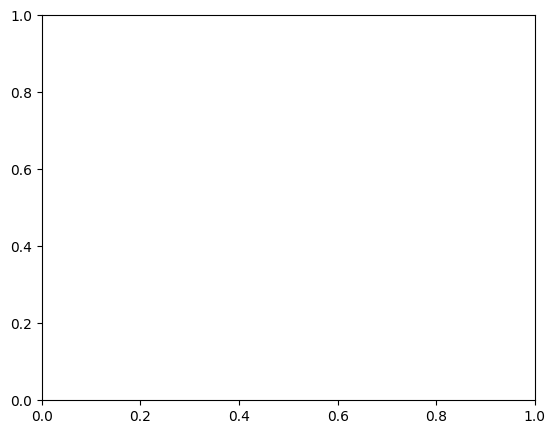

In [123]:
# 5.10) Gráfico comparativo de los tres experimentos

s = [i for i in range(1, num_epochs+1)]

# Gráfico de pérdidas
plt.figure(figsize=(14, 5))

# Subplot 1: Pérdidas de validación y entrenamiento
plt.subplot(1, 2, 1)
plt.plot(num_epochs, exp1_list_valid_loss, label='Exp1 - Valid', linestyle="-", c='red')
plt.plot(num_epochs, exp2_list_valid_loss, label='Exp2 - Valid', linestyle="-", c='blue')
plt.plot(num_epochs, exp3_list_valid_loss, label='Exp3 - Valid', linestyle="-", c='green')

plt.plot(num_epochs, exp1_list_train_loss, label='Exp1 - Train', linestyle=":", c='red')
plt.plot(num_epochs, exp2_list_train_loss, label='Exp2 - Train', linestyle=":", c='blue')
plt.plot(num_epochs, exp3_list_train_loss, label='Exp3 - Train', linestyle=":", c='green')

plt.title('Comparación de Pérdidas - Autoencoders')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Solo pérdidas de validación para mejor visualización
plt.subplot(1, 2, 2)
plt.plot(num_epochs, exp1_list_valid_loss, label='Exp1', linewidth=2, c='red')
plt.plot(num_epochs, exp2_list_valid_loss, label='Exp2', linewidth=2, c='blue')
plt.plot(num_epochs, exp3_list_valid_loss, label='Exp3', linewidth=2, c='green')

plt.title('Pérdidas de Validación - Comparación')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Imprimir pérdidas finales para comparación
print(f"Pérdidas finales de validación:")
print(f"Experimento 1: {exp1_list_valid_loss[-1]:.6f}")
print(f"Experimento 2: {exp2_list_valid_loss[-1]:.6f}")
print(f"Experimento 3: {exp3_list_valid_loss[-1]:.6f}")

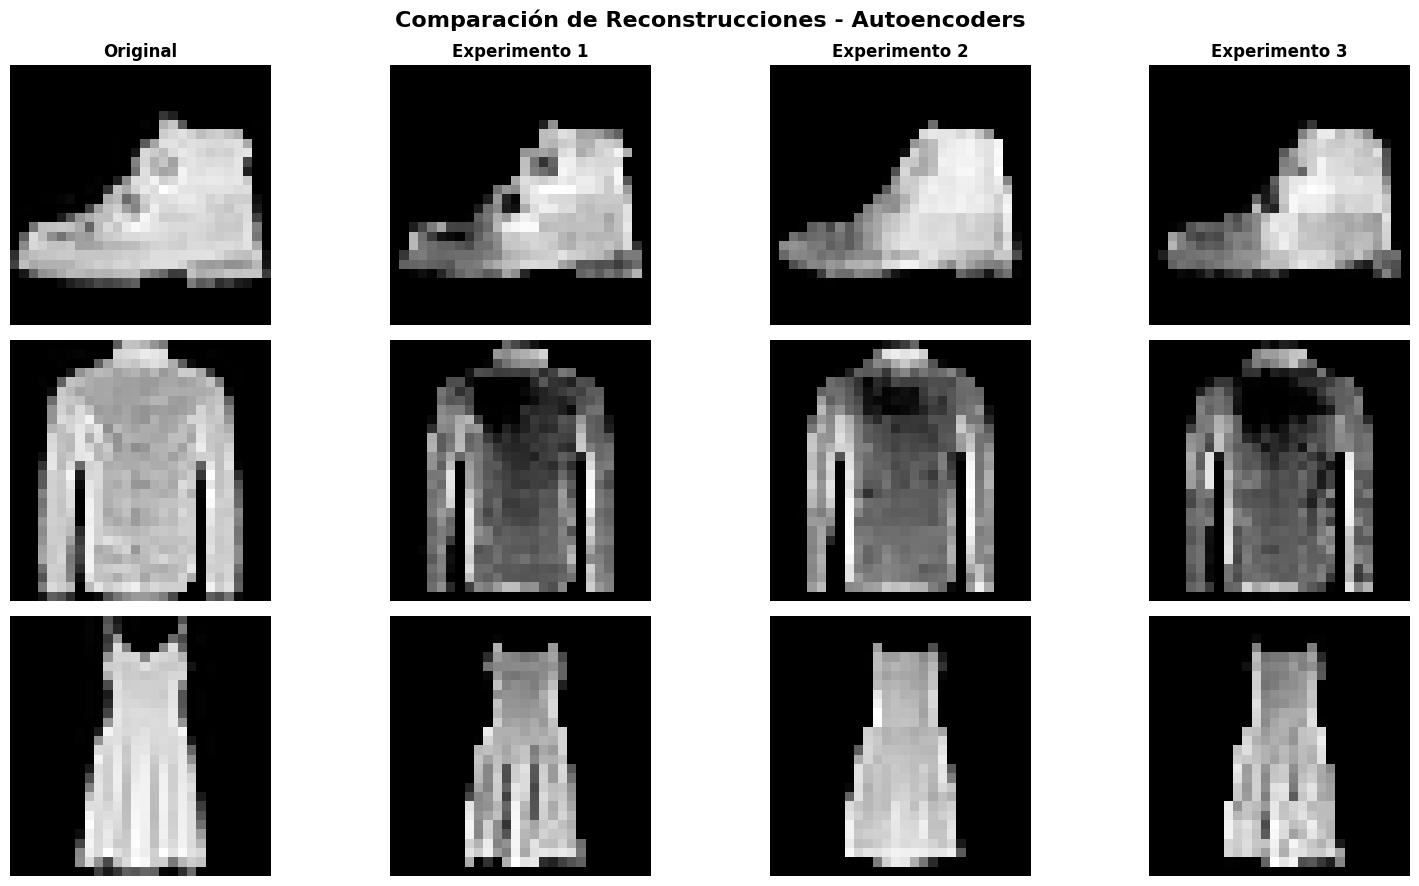


RESUMEN COMPARATIVO DE LOS EXPERIMENTOS
Experimento 1 (Decoder Simétrico):
  • Pérdida final de validación: 0.571350
  • Pérdida final de entrenamiento: 0.573778

Experimento 2 (Decoder con Más Capas):
  • Pérdida final de validación: 0.576233
  • Pérdida final de entrenamiento: 0.578565

Experimento 3 (Decoder con Capa Extra):
  • Pérdida final de validación: 0.574915
  • Pérdida final de entrenamiento: 0.577358

🏆 MEJOR RESULTADO: Experimento 1 con pérdida de validación de 0.571350


In [143]:
# 5.11) Comparación de reconstrucciones de los tres modelos entrenados
figure = plt.figure(figsize=(16, 9))
rows, cols = 3, 4  # 3 filas, 4 columnas (original + 3 experimentos)

# Ponemos todos los modelos en modo evaluación
exp1_model.eval()
exp2_model.eval()
exp3_model.eval()

for row in range(rows):
    # Seleccionamos una imagen aleatoria
    j = torch.randint(len(train_set), size=(1,)).item()
    image, _ = train_set[j]
    
    # Imagen original
    subplot_idx = row * cols + 1
    figure.add_subplot(rows, cols, subplot_idx)
    if row == 0:
        plt.title('Original', fontsize=12, fontweight='bold')
    plt.axis("off")
    plt.imshow(unbatch(image), cmap="Greys_r")
    
    # Predicción Experimento 1
    subplot_idx = row * cols + 2
    figure.add_subplot(rows, cols, subplot_idx)
    if row == 0:
        plt.title('Experimento 1', fontsize=12, fontweight='bold')
    plt.axis("off")
    with torch.no_grad():
        image_pred1 = unbatch(exp1_model(batch(image).to(device)))
    plt.imshow(image_pred1, cmap="Greys_r")
    
    # Predicción Experimento 2
    subplot_idx = row * cols + 3
    figure.add_subplot(rows, cols, subplot_idx)
    if row == 0:
        plt.title('Experimento 2', fontsize=12, fontweight='bold')
    plt.axis("off")
    with torch.no_grad():
        image_pred2 = unbatch(exp2_model(batch(image).to(device)))
    plt.imshow(image_pred2, cmap="Greys_r")
    
    # Predicción Experimento 3
    subplot_idx = row * cols + 4
    figure.add_subplot(rows, cols, subplot_idx)
    if row == 0:
        plt.title('Experimento 3', fontsize=12, fontweight='bold')
    plt.axis("off")
    with torch.no_grad():
        image_pred3 = unbatch(exp3_model(batch(image).to(device)))
    plt.imshow(image_pred3, cmap="Greys_r")

plt.suptitle('Comparación de Reconstrucciones - Autoencoders', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Mostrar resumen de resultados finales
print("\n" + "="*60)
print("RESUMEN COMPARATIVO DE LOS EXPERIMENTOS")
print("="*60)
print(f"Experimento 1 (Decoder Simétrico):")
print(f"  • Pérdida final de validación: {exp1_list_valid_loss[-1]:.6f}")
print(f"  • Pérdida final de entrenamiento: {exp1_list_train_loss[-1]:.6f}")
print(f"\nExperimento 2 (Decoder con Más Capas):")
print(f"  • Pérdida final de validación: {exp2_list_valid_loss[-1]:.6f}")
print(f"  • Pérdida final de entrenamiento: {exp2_list_train_loss[-1]:.6f}")
print(f"\nExperimento 3 (Decoder con Capa Extra):")
print(f"  • Pérdida final de validación: {exp3_list_valid_loss[-1]:.6f}")
print(f"  • Pérdida final de entrenamiento: {exp3_list_train_loss[-1]:.6f}")
print("\n" + "="*60)

# Determinar el mejor experimento
best_exp = min([(1, exp1_list_valid_loss[-1]), 
                (2, exp2_list_valid_loss[-1]), 
                (3, exp3_list_valid_loss[-1])], key=lambda x: x[1])
print(f"🏆 MEJOR RESULTADO: Experimento {best_exp[0]} con pérdida de validación de {best_exp[1]:.6f}")
print("="*60)



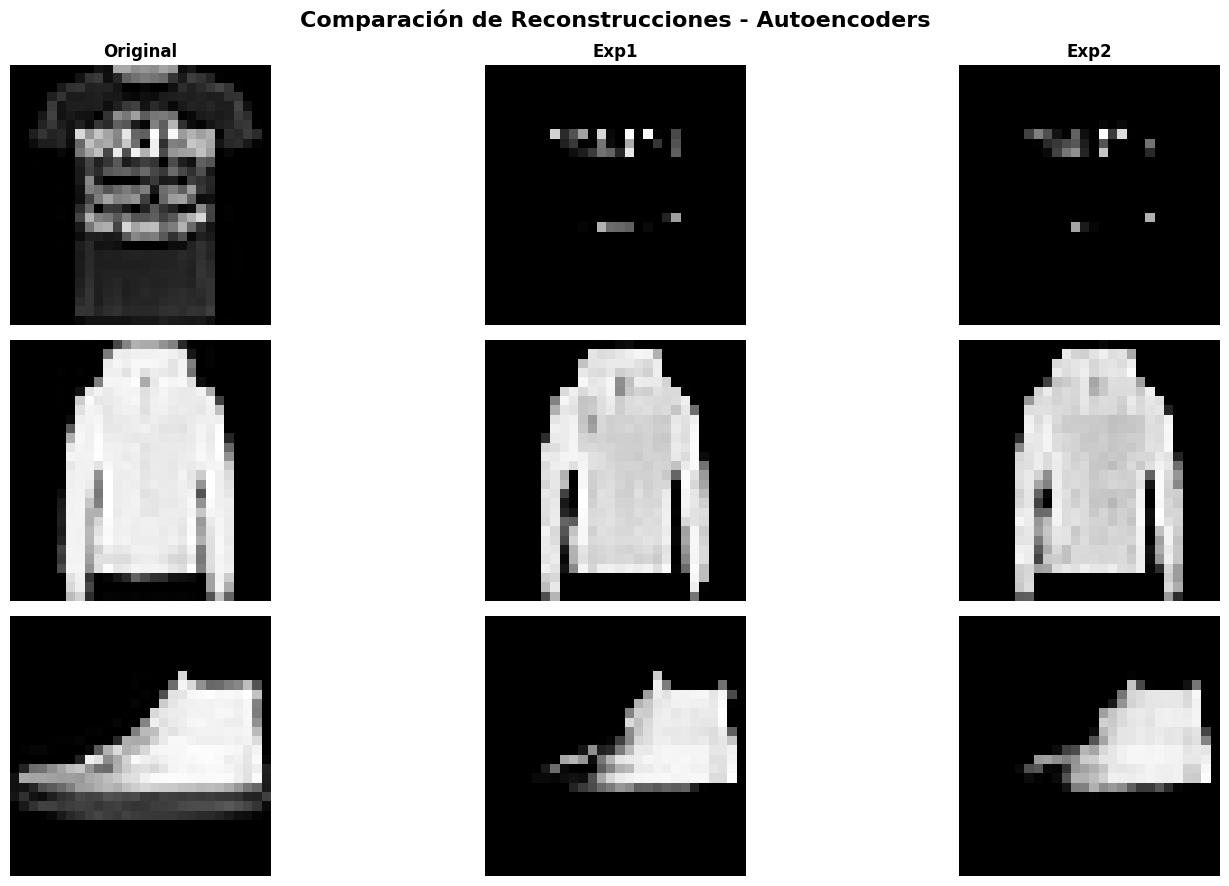


RESUMEN COMPARATIVO DE LOS EXPERIMENTOS
Experimento 1 (Decoder Simétrico):
  • Pérdida final de validación: 0.571350
  • Pérdida final de entrenamiento: 0.573778

Experimento 2 (Decoder con Capa Extra):
  • Pérdida final de validación: 0.574915
  • Pérdida final de entrenamiento: 0.577358

🏆 MEJOR RESULTADO: Experimento 1 con pérdida de validación de 0.571350


In [139]:
# 5.11) Comparación de reconstrucciones de los tres modelos entrenados
figure = plt.figure(figsize=(16, 9))
rows, cols = 3, 3  # 3 filas, 3 columnas (Original + Exp2 + Exp3)

# Ponemos los modelos en modo evaluación
exp2_model.eval()
exp3_model.eval()

for row in range(rows):
    # Seleccionamos una imagen aleatoria
    j = torch.randint(len(train_set), size=(1,)).item()
    image, _ = train_set[j]
    
    # Imagen original
    subplot_idx = row * cols + 1
    ax = figure.add_subplot(rows, cols, subplot_idx)
    if row == 0:
        ax.set_title('Original', fontsize=12, fontweight='bold')
    ax.axis("off")
    plt.imshow(unbatch(image), cmap="Greys_r")
    
    # Predicción Experimento 1
    subplot_idx = row * cols + 2
    figure.add_subplot(rows, cols, subplot_idx)
    if row == 0:
        plt.title('Exp1', fontsize=12, fontweight='bold')
    plt.axis("off")
    with torch.no_grad():
        image_pred1 = unbatch(exp1_model(batch(image).to(device)))
    plt.imshow(image_pred1, cmap="Greys_r")
    
    # Predicción Experimento 2
    subplot_idx = row * cols + 3
    ax = figure.add_subplot(rows, cols, subplot_idx)
    if row == 0:
        ax.set_title('Exp2', fontsize=12, fontweight='bold')
    ax.axis("off")
    with torch.no_grad():
        image_pred3 = unbatch(exp3_model(batch(image).to(device)))
    plt.imshow(image_pred3, cmap="Greys_r")


plt.suptitle('Comparación de Reconstrucciones - Autoencoders', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Mostrar resumen de resultados finales
print("\n" + "="*60)
print("RESUMEN COMPARATIVO DE LOS EXPERIMENTOS")
print("="*60)
print(f"Experimento 1 (Decoder Simétrico):")
print(f"  • Pérdida final de validación: {exp1_list_valid_loss[-1]:.6f}")
print(f"  • Pérdida final de entrenamiento: {exp1_list_train_loss[-1]:.6f}")
print(f"\nExperimento 2 (Decoder con Capa Extra):")
print(f"  • Pérdida final de validación: {exp3_list_valid_loss[-1]:.6f}")
print(f"  • Pérdida final de entrenamiento: {exp3_list_train_loss[-1]:.6f}")
print("\n" + "="*60)

# Determinar el mejor experimento
best_exp = min([(1, exp1_list_valid_loss[-1]), 
                (2, exp3_list_valid_loss[-1])], key=lambda x: x[1])
print(f"🏆 MEJOR RESULTADO: Experimento {best_exp[0]} con pérdida de validación de {best_exp[1]:.6f}")
print("="*60)

